<a href="https://colab.research.google.com/github/DevBatra05/DeepLearningLab/blob/main/Lab_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image Reconstruction and Feature Compression Using Autoencoders*

In [8]:
!pip install -q kagglehub

import os
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [9]:
# Download dataset
path = kagglehub.dataset_download("l3llff/flowers")
print("Root dataset path:", path)

# In this dataset there is a folder "flowers" containing class folders
IMAGE_ROOT = os.path.join(path, "flowers")
print("Images directory:", IMAGE_ROOT)

# Quick check of folders
print(os.listdir(IMAGE_ROOT))


Using Colab cache for faster access to the 'flowers' dataset.
Root dataset path: /kaggle/input/flowers
Images directory: /kaggle/input/flowers/flowers
['astilbe', 'daffodil', 'black_eyed_susan', 'bellflower', 'common_daisy', 'coreopsis', 'dandelion', 'water_lily', 'carnation', 'calendula', 'california_poppy', 'sunflower', 'tulip', 'rose', 'magnolia', 'iris']


In [10]:
IMG_HEIGHT = 128
IMG_WIDTH  = 128
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE


In [11]:
# Dataset with labels just to see class names (optional)
flower_ds_with_labels = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_ROOT,
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

class_names = flower_ds_with_labels.class_names
print("Flower classes:", class_names)


Found 15740 files belonging to 16 classes.
Flower classes: ['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion', 'iris', 'magnolia', 'rose', 'sunflower', 'tulip', 'water_lily']


In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_ROOT,
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    labels=None,                # images only
    validation_split=0.2,
    subset='training'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMAGE_ROOT,
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    labels=None,
    validation_split=0.2,
    subset='validation'
)


Found 15740 files.
Using 12592 files for training.
Found 15740 files.
Using 3148 files for validation.


In [13]:
def replicate_inputs_to_outputs(images):
    images = tf.cast(images, tf.float32) / 255.0
    return images, images

train_ds = train_ds.map(replicate_inputs_to_outputs).cache().prefetch(AUTOTUNE)
val_ds   = val_ds.map(replicate_inputs_to_outputs).cache().prefetch(AUTOTUNE)


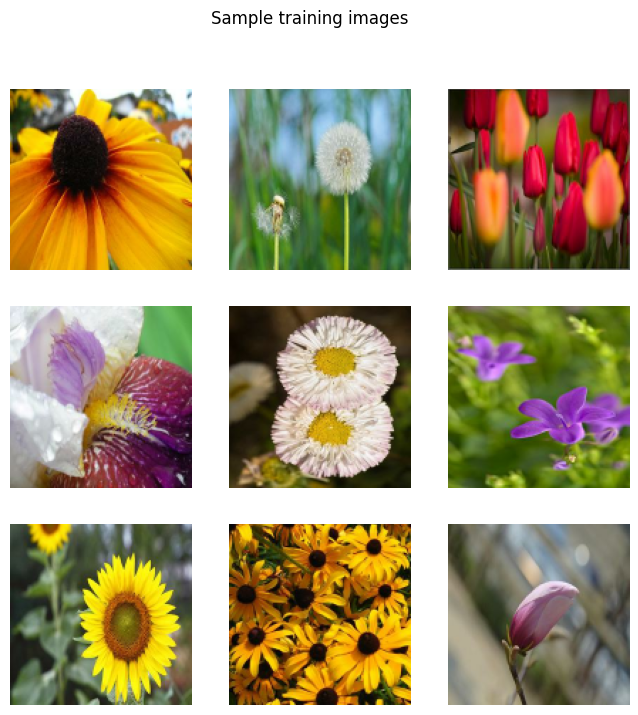

In [14]:
sample_batch, _ = next(iter(train_ds))
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_batch[i])
    plt.axis("off")
plt.suptitle("Sample training images")
plt.show()


In [15]:
latent_dim = 128   # compressed representation size

encoder_inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

x = layers.Conv2D(32, 3, activation="relu", padding="same")(encoder_inputs)
x = layers.MaxPool2D(2)(x)                    # 64×64

x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPool2D(2)(x)                    # 32×32

x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
x = layers.MaxPool2D(2)(x)                    # 16×16

x = layers.Flatten()(x)
latent = layers.Dense(latent_dim, name="latent_vector")(x)

encoder = keras.Model(encoder_inputs, latent, name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 128)            │     4,194,432 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,680 (16.36 MB)

 Trainable params: 4,287,680 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
decoder_inputs = keras.Input(shape=(latent_dim,))

# match encoder flatten size: 16 * 16 * 128
x = layers.Dense(16 * 16 * 128, activation="relu")(decoder_inputs)
x = layers.Reshape((16, 16, 128))(x)

# upsampling with transposed convs
x = layers.Conv2DTranspose(128, 3, strides=2, activation="relu", padding="same")(x)  # 32x32
x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)   # 64x64
x = layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)   # 128x128 ✅

# final reconstruction layer
decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32768)          │     4,227,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,467,779 (17.04 MB)

 Trainable params: 4,467,779 (17.04 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
autoencoder_inputs = encoder_inputs
encoded = encoder(autoencoder_inputs)
decoded = decoder(encoded)

autoencoder = keras.Model(autoencoder_inputs, decoded, name="autoencoder")
autoencoder.summary()


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 128)            │     4,287,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 128, 128, 3)    │     4,467,779 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,755,459 (33.40 MB)

 Trainable params: 8,755,459 (33.40 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",                # mean squared error
    metrics=["mae"]            # mean absolute error (optional metric)
)


In [22]:
EPOCHS = 5  # you can start with 5 to test, then increase

history = autoencoder.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 1260s 3s/step - loss: 0.0565 - mae: 0.1884 - val_loss: 0.0275 - val_mae: 0.1217
Epoch 2/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 1284s 3s/step - loss: 0.0260 - mae: 0.1179 - val_loss: 0.0219 - val_mae: 0.1069
Epoch 3/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 1236s 3s/step - loss: 0.0205 - mae: 0.1026 - val_loss: 0.0182 - val_mae: 0.0947
Epoch 4/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 1236s 3s/step - loss: 0.0176 - mae: 0.0934 - val_loss: 0.0170 - val_mae: 0.0904
Epoch 5/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 1233s 3s/step - loss: 0.0161 - mae: 0.0889 - val_loss: 0.0160 - val_mae: 0.0879


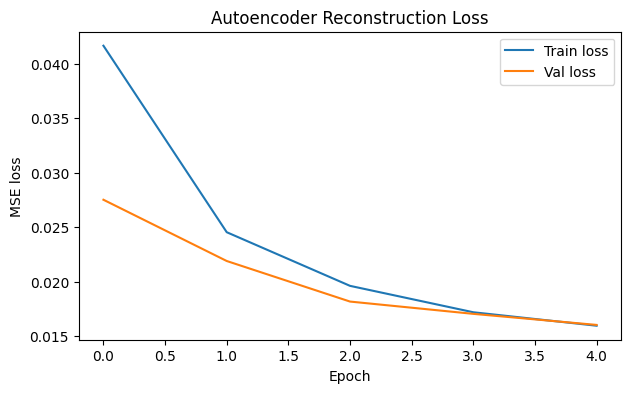

In [23]:
plt.figure(figsize=(7,4))
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.title("Autoencoder Reconstruction Loss")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


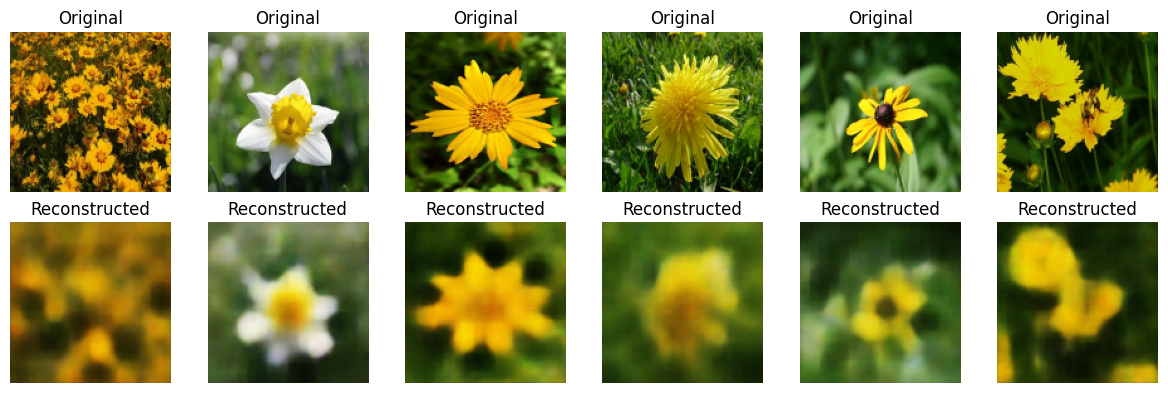

In [24]:
# Take one batch from validation set
x_batch, _ = next(iter(val_ds))

# Get reconstructions
reconstructions = autoencoder.predict(x_batch)

n = 6  # how many images to show
plt.figure(figsize=(12,4))
for i in range(n):
    # Original
    plt.subplot(2, n, i+1)
    plt.imshow(x_batch[i])
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    plt.subplot(2, n, i+1+n)
    plt.imshow(reconstructions[i])
    plt.title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [25]:
# Pass one batch through encoder to see latent vector
latent_vectors = encoder.predict(x_batch)
print("Latent vectors shape:", latent_vectors.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
Latent vectors shape: (32, 128)


In [26]:
autoencoder.save("flowers_autoencoder.h5")
encoder.save("flowers_encoder.h5")
decoder.save("flowers_decoder.h5")
